# Transfer Matrix Calculations

### initial stuff

import necessary pacakges 

if this is used in a paper cite Steven J. Brynes (creator of tmm package) arxiv paper: https://arxiv.org/pdf/1603.02720.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d

#ColorPy package allows you to convert a spectrum into a color you would see
#downloaded from Github https://github.com/fish2000/ColorPy 
#note that PyPI version is only compatible with Python 2 - Github is compatible with 2 & 3
from colorpy import colormodels, illuminants 

#TMM package does all transfer matrix calculations
#installed from PyPI
from tmm import coh_tmm, absorp_in_each_layer, color, position_resolved

define plot style

In [2]:
%config InlineBackend.figure_format = 'retina' #to make inline images higher res

plt.style.use(['presplot']) #this is a plot format that I have in my style folder on my computer
#plt.rcParams["figure.figsize"] = [8,8]

load nk data - as a dictionary with the different materials as items, arrays are lambda (microns), n, k

In [3]:
nkdata_raw = scipy.io.loadmat('nkdata.mat')

## calculate absorbtion in each layer of a stack

### > input parameters here <
initialize stack parameters

In [4]:
# list of materials in stack
mat_list=np.array(["SiO_2","Pt","WS_2","Ag"])

# list of layer thicknesses in nm, start and end with inf
d_list = np.array([np.inf,1700,10,80,100,np.inf])

# list of wavelengths
ldas=np.arange(380,820,1).reshape(-1,1)

#polarization
pol="s"

#angle
theta=0;

### transfer matrix stuff

interpolate nk data

In [5]:
nkdata={}
for mat in mat_list:
    raw=nkdata_raw[mat+"_raw"]
    n_raw=interp1d(raw[:,0],raw[:,1],fill_value="extrapolate")
    k_raw=interp1d(raw[:,0],raw[:,2],fill_value="extrapolate")
    n=n_raw(ldas/1000)
    k=k_raw(ldas/1000)
    nkdata[mat]=np.column_stack((ldas,n,k))

actual transfer matrix calculation

In [6]:
#initialize all matrices
R=np.zeros(np.shape(ldas))
T=np.zeros(np.shape(ldas))
A=np.zeros(np.shape(ldas))
a_layer=np.zeros((np.size(ldas),np.size(mat_list)))

#loop over all wavelengths
i=0
for lda in ldas:    
    
    #initialize n_list, index
    n_list=np.ones(np.size(d_list),dtype=complex)
    j=0
    
    #calculate n,k at this wavelength for each material, populate n_list
    for mat in mat_list:
        j+=1
        nk=nkdata[mat]
        n_list[j]=nk[i,1]+nk[i,2]*1j
        
    #TMM
    coh_tmm_data=coh_tmm(pol,n_list,d_list,theta,lda)
    
    #absorption in each layer
    a=absorp_in_each_layer(coh_tmm_data)
    
    #add to arrays 
    R[i,0]=coh_tmm_data["R"]
    T[i,0]=coh_tmm_data["T"]
    A[i,0]=1-coh_tmm_data["R"]-coh_tmm_data["T"]
    a_layer[i,:]=a[1:np.size(mat_list)+1]

    i+=1

### plots

plot absorption in all layers

(0, 1)

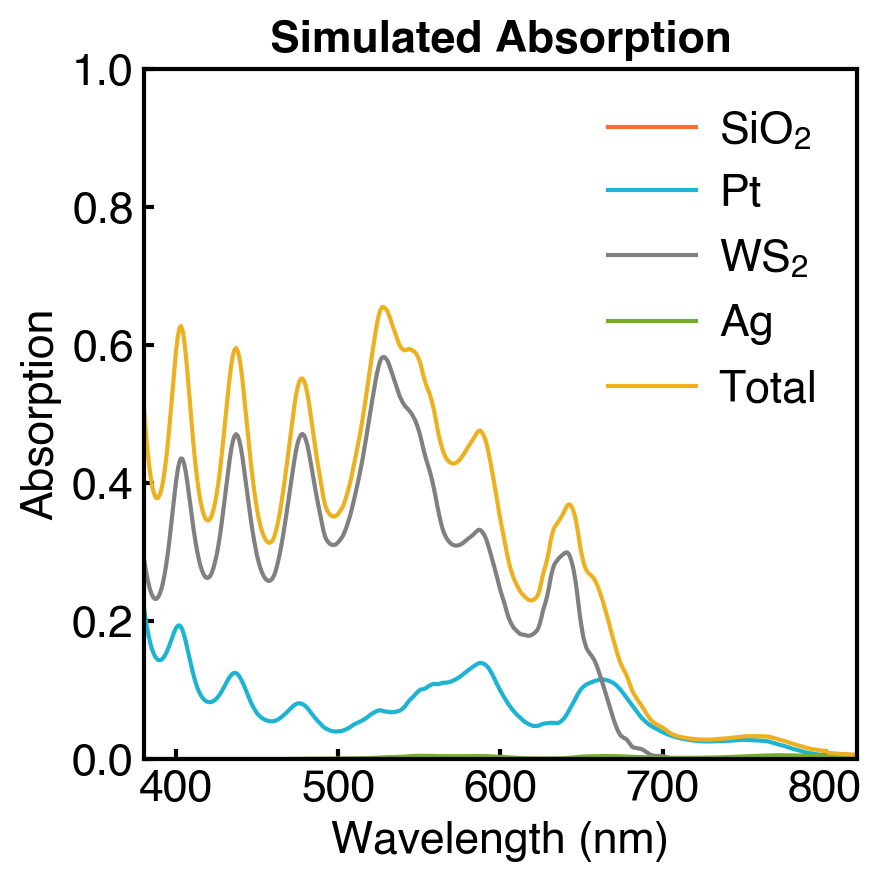

In [7]:
fig,ax=plt.subplots()

i=0
for mat in mat_list:
    ax.plot(ldas,a_layer[:,i],label="$"+mat+"$")
    i+=1
    
ax.plot(ldas,np.sum(a_layer,axis=1),label="Total")    
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorption")
ax.legend(loc="upper right")
ax.set_title('Simulated Absorption')
ax.set_xlim([380,820])
ax.set_ylim([0,1])

## color from spectrum calculation

determine color of exfoliated flake

### > input parameters here <

In [8]:
d_initial=15 #will refer to thickness of flake for second plot of reflectance
color_mat_list=np.array(["WS_2","PDMS","SiO_2"])
color_d_list=np.array([np.inf,d_initial,1e6,1e6,np.inf]) #thicknesses in nm
thickness_list=np.arange(0,50,2)

calculate reflectance for thickness d_initial and plot

In [9]:
air_n_fn = lambda wavelength : 1
n_fn_list=[air_n_fn]
for mat in color_mat_list:
    raw=nkdata_raw[mat+"_raw"]
    mat_n_fn=interp1d(raw[:,0]*1000,raw[:,1]+raw[:,2]*1j,fill_value="extrapolate")
    n_fn_list.append(mat_n_fn)
n_fn_list.append(air_n_fn)

reflectance = color.calc_reflectances(n_fn_list, color_d_list, theta)
illuminant = illuminants.get_illuminant_D65()
spectrum = color.calc_spectrum(reflectance, illuminant)
color_dict = color.calc_color(spectrum)
color_string = colormodels.irgb_string_from_irgb(color_dict["irgb"])

plot reflectance, apparent color is in background

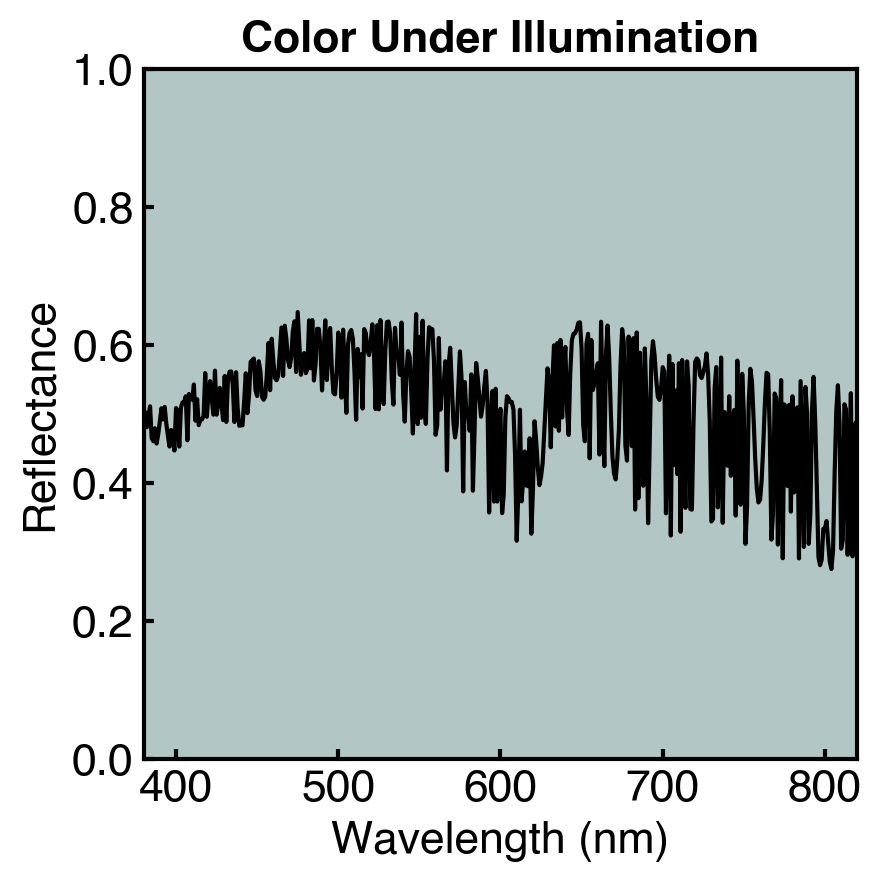

In [10]:
fig,ax=plt.subplots()

ax.plot(reflectance[:,0],reflectance[:,1],'black')    
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")
ax.set_title('Color Under Illumination')
ax.set_xlim([380,820])
ax.set_ylim([0,1])
ax.set_facecolor(color_string)

calculate color for all thicknesses in color_d_list

In [11]:
irgb_list=[]
max_thickness=thickness_list[len(thickness_list)-1]

index=1
for t in thickness_list:
    color_d_list[index]=t

    reflectances = color.calc_reflectances(n_fn_list, color_d_list, theta)
    illuminant = illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    color_string = colormodels.irgb_string_from_irgb(color_dict["irgb"])
    
    irgb_list.append(color_string)

plot range of colors for different TMD thicknesses (adopeted from TMM package example file)

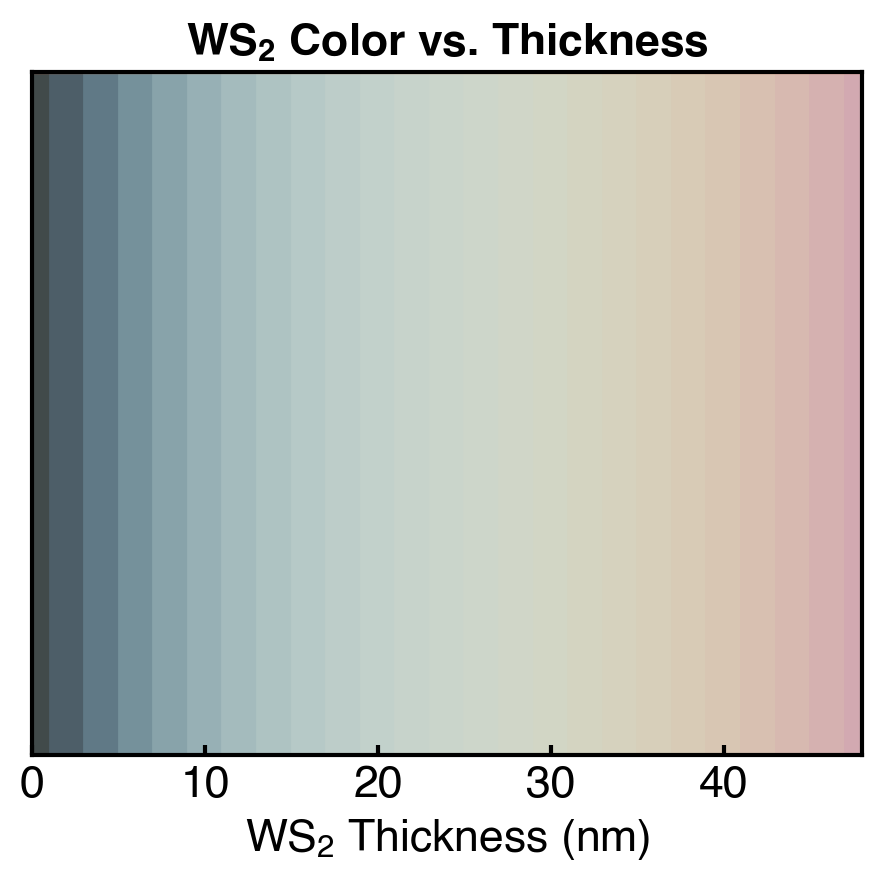

In [12]:
fig=plt.figure()
plt.plot([0,max_thickness],[1,1])
plt.xlim(0,max_thickness)
plt.ylim(0,1)
plt.xlabel('$WS_2$ Thickness (nm)')
plt.yticks([])
plt.title('$WS_2$ Color vs. Thickness')

for i in range(len(thickness_list)):
    # One strip of each color, centered at x=thickness_list[i]
    if i==0:
        x0 = 0
    else:
        x0 = (thickness_list[i] + thickness_list[i-1]) / 2
    if i == len(thickness_list) - 1:
        x1 = max_thickness
    else:
        x1 = (thickness_list[i] + thickness_list[i+1]) / 2
    y0 = 0
    y1 = 1
    poly_x = [x0,  x1,  x1, x0]
    poly_y = [y0, y0, y1, y1]
    color_string = irgb_list[i]
    plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)
    
#fig.savefig('color-vs-thickness.png')